In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange
import scipy.stats
import pandas as pd
from scipy.stats import rankdata

# WeightedCorr code

In [2]:
class WeightedCorr:
    def __init__(self, xyw=None, x=None, y=None, w=None, df=None, wcol=None):
        ''' Weighted Correlation class. Either supply xyw, (x, y, w), or (df, wcol). Call the class to get the result, i.e.:
        WeightedCorr(xyw=mydata[[x, y, w]])(method='pearson')
        :param xyw: pd.DataFrame with shape(n, 3) containing x, y, and w columns (column names irrelevant)
        :param x: pd.Series (n, ) containing values for x
        :param y: pd.Series (n, ) containing values for y
        :param w: pd.Series (n, ) containing weights
        :param df: pd.Dataframe (n, m+1) containing m phenotypes and a weight column
        :param wcol: str column of the weight column in the dataframe passed to the df argument.
        '''
        if (df is None) and (wcol is None):
            if np.all([i is None for i in [xyw, x, y, w]]):
                raise ValueError('No data supplied')
            if not ((isinstance(xyw, pd.DataFrame)) != (np.all([isinstance(i, pd.Series) for i in [x, y, w]]))):
                raise TypeError('xyw should be a pd.DataFrame, or x, y, w should be pd.Series')
            xyw = pd.concat([x, y, w], axis=1).dropna() if xyw is None else xyw.dropna()
            self.x, self.y, self.w = (pd.to_numeric(xyw[i], errors='coerce').values for i in xyw.columns)
            self.df = None
        elif (wcol is not None) and (df is not None):
            if (not isinstance(df, pd.DataFrame)) or (not isinstance(wcol, str)):
                raise ValueError('df should be a pd.DataFrame and wcol should be a string')
            if wcol not in df.columns:
                raise KeyError('wcol not found in column names of df')
            self.df = df.loc[:, [x for x in df.columns if x != wcol]]
            self.w = pd.to_numeric(df.loc[:, wcol], errors='coerce')
        else:
            raise ValueError('Incorrect arguments specified, please specify xyw, or (x, y, w) or (df, wcol)')

    def _wcov(self, x, y, ms):
        return np.sum(self.w * (x - ms[0]) * (y - ms[1]))

    def _pearson(self, x=None, y=None):
        x, y = (self.x, self.y) if ((x is None) and (y is None)) else (x, y)
        mx, my = (np.sum(i * self.w) / np.sum(self.w) for i in [x, y])
        return self._wcov(x, y, [mx, my]) / np.sqrt(self._wcov(x, x, [mx, mx]) * self._wcov(y, y, [my, my]))

    def _wrank(self, x):
        (unique, arr_inv, counts) = np.unique(rankdata(x), return_counts=True, return_inverse=True)
        a = np.bincount(arr_inv, self.w)
        return (np.cumsum(a) - a)[arr_inv]+((counts + 1)/2 * (a/counts))[arr_inv]

    def _spearman(self, x=None, y=None):
        x, y = (self.x, self.y) if ((x is None) and (y is None)) else (x, y)
        return self._pearson(self._wrank(x), self._wrank(y))

    def __call__(self, method='pearson'):
        '''
        :param method: Correlation method to be used: 'pearson' for pearson r, 'spearman' for spearman rank-order correlation.
        :return: if xyw, or (x, y, w) were passed to __init__ returns the correlation value (float).
                 if (df, wcol) were passed to __init__ returns a pd.DataFrame (m, m), the correlation matrix.
        '''
        if method not in ['pearson', 'spearman']:
            raise ValueError('method should be one of [\'pearson\', \'spearman\']')
        cor = {'pearson': self._pearson, 'spearman': self._spearman}[method]
        if self.df is None:
            return cor()
        else:
            out = pd.DataFrame(np.nan, index=self.df.columns, columns=self.df.columns)
            for i, x in enumerate(self.df.columns):
                for j, y in enumerate(self.df.columns):
                    if i >= j:
                        out.loc[x, y] = cor(x=pd.to_numeric(self.df[x], errors='coerce'), y=pd.to_numeric(self.df[y], errors='coerce'))
                        out.loc[y, x] = out.loc[x, y]
            return out

# RSA

In [3]:
rep_no = 5

C4_diff_all = np.zeros((rep_no, 2000,2000))
C4_nona_all = np.zeros((rep_no, 2000,2000))
C8_diff_all = np.zeros((rep_no, 2000,2000))
C8_nona_all = np.zeros((rep_no, 2000,2000))
C12_diff_all = np.zeros((rep_no, 2000,2000))
C12_nona_all = np.zeros((rep_no, 2000,2000))

C4_diff_scale_all = np.zeros((rep_no, 2000))
C4_nona_scale_all = np.zeros((rep_no, 2000))
C8_diff_scale_all = np.zeros((rep_no, 2000))
C8_nona_scale_all = np.zeros((rep_no, 2000))
C12_diff_scale_all = np.zeros((rep_no, 2000))
C12_nona_scale_all = np.zeros((rep_no, 2000))

C4_rand_all = np.zeros((rep_no, 2000, 2000))
C4_rand_scale_all = np.random.rand(rep_no, 2000)
C8_rand_all = np.zeros((rep_no, 2000, 2000))
C8_rand_scale_all = np.random.rand(rep_no, 2000)
C12_rand_all = np.zeros((rep_no, 2000, 2000))
C12_rand_scale_all = np.random.rand(rep_no, 2000)

for i in tnrange(rep_no):
    C4_diff_raw = np.load("/media/hdd01/sklee/CA1_clust4-60/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C4_nona_raw = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C8_diff_raw = np.load("/media/hdd01/sklee/CA1_clust8-30/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C8_nona_raw = np.load("/media/hdd01/sklee/CA1_clust8-30_noNA/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C12_diff_raw = np.load("/media/hdd01/sklee/CA1_clust12-20/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]
    C12_nona_raw = np.load("/media/hdd01/sklee/CA1_clust12-20_noNA/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"]

    C4_dist_raw = np.load("/media/hdd01/sklee/CA1_clust4-60/data/clust4_syn_dist.npy")[:,-1]
    C8_dist_raw = np.load("/media/hdd01/sklee/CA1_clust8-30/data/clust8_syn_dist.npy")[:,-1]
    C12_dist_raw = np.load("/media/hdd01/sklee/CA1_clust12-20/data/clust12_syn_dist.npy")[:,-1]

    C4_diff_scale = np.load("/media/hdd01/sklee/CA1_clust4-60/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C4_nona_scale = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C8_diff_scale = np.load("/media/hdd01/sklee/CA1_clust8-30/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C8_nona_scale = np.load("/media/hdd01/sklee/CA1_clust8-30_noNA/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C12_diff_scale = np.load("/media/hdd01/sklee/CA1_clust12-20/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    C12_nona_scale = np.load("/media/hdd01/sklee/CA1_clust12-20_noNA/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["E_scale"]
    
    C4_diff_scale_all[i] = C4_diff_scale
    C4_nona_scale_all[i] = C4_nona_scale
    C8_diff_scale_all[i] = C8_diff_scale
    C8_nona_scale_all[i] = C8_nona_scale
    C12_diff_scale_all[i] = C12_diff_scale
    C12_nona_scale_all[i] = C12_nona_scale
    
    C4_diff_idx = np.zeros((2000))
    C4_nona_idx = np.zeros((2000))
    C8_diff_idx = np.zeros((2000))
    C8_nona_idx = np.zeros((2000))
    C12_diff_idx = np.zeros((2000))
    C12_nona_idx = np.zeros((2000))
    
    C4_rand_idx = np.random.randint(0,5,(2000))
    C8_rand_idx = np.random.randint(0,8,(2000))
    C12_rand_idx = np.random.randint(0,12,(2000))

    for j in range(2000):
        C4_diff_idx[j] = np.argmax(C4_diff_raw[:,j])
        C4_nona_idx[j] = np.argmax(C4_nona_raw[:,j])
        C8_diff_idx[j] = np.argmax(C8_diff_raw[:,j])
        C8_nona_idx[j] = np.argmax(C8_nona_raw[:,j])
        C12_diff_idx[j] = np.argmax(C12_diff_raw[:,j])
        C12_nona_idx[j] = np.argmax(C12_nona_raw[:,j])

    for j in range(2000):
        for k in range(2000):
            if C4_diff_idx[j] != C4_diff_idx[k]:
                C4_diff_all[i,j,k] = 1
                C4_diff_all[i,k,j] = 1
            if C4_nona_idx[j] != C4_nona_idx[k]:
                C4_nona_all[i,j,k] = 1
                C4_nona_all[i,k,j] = 1
            if C8_diff_idx[i] != C8_diff_idx[k]:
                C8_diff_all[i,j,k] = 1
                C8_diff_all[i,k,j] = 1
            if C8_nona_idx[j] != C8_nona_idx[k]:
                C8_nona_all[i,j,k] = 1
                C8_nona_all[i,k,j] = 1
            if C12_diff_idx[j] != C12_diff_idx[k]:
                C12_diff_all[i,j,k] = 1
                C12_diff_all[i,k,j] = 1
            if C12_nona_idx[j] != C12_nona_idx[k]:
                C12_nona_all[i,j,k] = 1
                C12_nona_all[i,k,j] = 1
            if C4_rand_idx[j] != C4_rand_idx[k]:
                C4_rand_all[i,j,k] = 1
                C4_rand_all[i,k,j] = 1
            if C8_rand_idx[j] != C8_rand_idx[k]:
                C8_rand_all[i,j,k] = 1
                C8_rand_all[i,k,j] = 1
            if C12_rand_idx[j] != C12_rand_idx[k]:
                C12_rand_all[i,j,k] = 1
                C12_rand_all[i,k,j] = 1

<ipython-input-3-b09bc4eb957b>:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(rep_no):


  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
C4_diff_mean = np.mean(C4_diff_all, 0)
C4_nona_mean = np.mean(C4_nona_all, 0)
C8_diff_mean = np.mean(C8_diff_all, 0)
C8_nona_mean = np.mean(C8_nona_all, 0)
C12_diff_mean = np.mean(C12_diff_all, 0)
C12_nona_mean = np.mean(C12_nona_all, 0)

C4_diff_scale_mean = np.mean(C4_diff_scale_all, 0)
C4_nona_scale_mean = np.mean(C4_nona_scale_all, 0)
C8_diff_scale_mean = np.mean(C8_diff_scale_all, 0)
C8_nona_scale_mean = np.mean(C8_nona_scale_all, 0)
C12_diff_scale_mean = np.mean(C12_diff_scale_all, 0)
C12_nona_scale_mean = np.mean(C12_nona_scale_all, 0)

C4_rand_mean = np.mean(C4_rand_all, 0)
C8_rand_mean = np.mean(C8_rand_all, 0)
C12_rand_mean = np.mean(C12_rand_all, 0)

C4_rand_scale_mean = np.mean(C4_rand_scale_all, 0)
C8_rand_scale_mean = np.mean(C8_rand_scale_all, 0)
C12_rand_scale_mean = np.mean(C12_rand_scale_all, 0)


In [5]:
C4_clust_idx = np.zeros((2000))
C8_clust_idx = np.zeros((2000))
C12_clust_idx = np.zeros((2000))

for i in range(4):
    C4_clust_idx[880+60*i:880+60*(i+1)] = i+1
for i in range(8):
    C8_clust_idx[880+30*i:880+30*(i+1)] = i+1
for i in range(12):
    C12_clust_idx[880+20*i:880+20*(i+1)] = i+1
    
C4_clust = np.zeros((2000,2000))
C8_clust = np.zeros((2000,2000))
C12_clust = np.zeros((2000,2000))

for i in tnrange(2000):
    for j in range(2000):
        if C4_clust_idx[i] != C4_clust_idx[j]:
            C4_clust[i,j] = 1
            C4_clust[j,i] = 1
        if C8_clust_idx[i] != C8_clust_idx[j]:
            C8_clust[i,j] = 1
            C8_clust[j,i] = 1
        if C12_clust_idx[i] != C12_clust_idx[j]:
            C12_clust[i,j] = 1
            C12_clust[j,i] = 1

<ipython-input-5-28c7df3d81b5>:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(2000):


  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
C4_dist = np.zeros((2000,2000))
C8_dist = np.zeros((2000,2000))
C12_dist = np.zeros((2000,2000))

for i in tnrange(2000):
    for j in range(2000):
        C4_dist[i,j] = np.abs(C4_dist_raw[i] - C4_dist_raw[j])
        C8_dist[i,j] = np.abs(C8_dist_raw[i] - C8_dist_raw[j])
        C12_dist[i,j] = np.abs(C12_dist_raw[i] - C12_dist_raw[j])

<ipython-input-6-e900bb5569b8>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(2000):


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
x, y = np.triu_indices(2000, k=0)
x_part, y_part = np.triu_indices(240, k=0)
x_part += 880
y_part += 880

within_corrs = np.zeros((rep_no*(rep_no-1)//2,9))
across_corrs = np.zeros((rep_no**2,3))
dist_corrs = np.zeros((rep_no,9))
clust_corrs = np.zeros((rep_no,9))

across_mean_corrs = np.zeros((3))
dist_mean_corrs = np.zeros((9))
clust_mean_corrs = np.zeros((9))

for i in tnrange(3):
    if i == 0:
        dist_mat = C4_dist
        clust_mat = C4_clust
        diff_mat_all = C4_diff_all
        nona_mat_all = C4_nona_all
        diff_mat_mean = C4_diff_mean
        nona_mat_mean = C4_nona_mean
        rand_mat_all = C4_rand_all
        rand_mat_mean = C4_rand_mean
    elif i == 1:
        dist_mat = C8_dist
        clust_mat = C8_clust
        diff_mat_all = C8_diff_all
        nona_mat_all = C8_nona_all
        diff_mat_mean = C8_diff_mean
        nona_mat_mean = C8_nona_mean
        rand_mat_all = C8_rand_all
        rand_mat_mean = C8_rand_mean
    elif i == 2:
        dist_mat = C12_dist
        clust_mat = C12_clust
        diff_mat_all = C12_diff_all
        nona_mat_all = C12_nona_all
        diff_mat_mean = C12_diff_mean
        nona_mat_mean = C12_nona_mean
        rand_mat_all = C12_rand_all
        rand_mat_mean = C12_rand_mean
        
    across_count = 0
    within_count = 0
    for j in range(rep_no):
        for k in range(rep_no):
            across_corr_val, _ = scipy.stats.spearmanr(diff_mat_all[j][x,y], nona_mat_all[k][x,y])
            across_corrs[across_count,i] = across_corr_val
            across_count += 1
        for k in range(j+1,rep_no,1):
            within_diff_corr_val, _ = scipy.stats.spearmanr(diff_mat_all[j][x,y], diff_mat_all[k][x,y])
            within_nona_corr_val, _ = scipy.stats.spearmanr(nona_mat_all[j][x,y], nona_mat_all[k][x,y])
            within_corrs[within_count,i*2] = within_nona_corr_val
            within_corrs[within_count,i*2+1] = within_diff_corr_val
            within_rand_corr_val, _ = scipy.stats.spearmanr(rand_mat_all[j][x,y], rand_mat_all[k][x,y])
            within_corrs[within_count,i+6] = within_rand_corr_val
            within_count += 1
            
        dist_nona_corr_val, _ = scipy.stats.spearmanr(dist_mat[x,y], nona_mat_all[j][x,y])
        dist_diff_corr_val, _ = scipy.stats.spearmanr(dist_mat[x,y], diff_mat_all[j][x,y])
        dist_corrs[j,i*2] = dist_nona_corr_val
        dist_corrs[j,i*2+1] = dist_diff_corr_val
        dist_rand_corr_val, _ = scipy.stats.spearmanr(dist_mat[x,y], rand_mat_all[j][x,y])
        dist_corrs[j,i+6] = dist_rand_corr_val
        
        clust_nona_corr_val, _ = scipy.stats.spearmanr(clust_mat[x_part,y_part], nona_mat_all[j][x_part,y_part])
        clust_diff_corr_val, _ = scipy.stats.spearmanr(clust_mat[x_part,y_part], diff_mat_all[j][x_part,y_part])
        clust_corrs[j,i*2] = clust_nona_corr_val
        clust_corrs[j,i*2+1] = clust_diff_corr_val
        clust_rand_corr_val, _ = scipy.stats.spearmanr(clust_mat[x,y], rand_mat_all[j][x,y])
        clust_corrs[j,i+6] = clust_rand_corr_val
        
    across_corr_val, _ = scipy.stats.spearmanr(diff_mat_mean[x,y], nona_mat_mean[x,y])
    across_mean_corrs[i] = across_corr_val
    
    dist_nona_corr_val, _ = scipy.stats.spearmanr(dist_mat[x,y], nona_mat_mean[x,y])
    dist_diff_corr_val, _ = scipy.stats.spearmanr(dist_mat[x,y], diff_mat_mean[x,y])
    dist_mean_corrs[i*2] = dist_nona_corr_val
    dist_mean_corrs[i*2+1] = dist_diff_corr_val
    dist_rand_corr_val, _ = scipy.stats.spearmanr(dist_mat[x,y], rand_mat_mean[x,y])
    dist_mean_corrs[i+6] = dist_rand_corr_val
    
    clust_nona_corr_val, _ = scipy.stats.spearmanr(clust_mat[x_part,y_part], nona_mat_mean[x_part,y_part])
    clust_diff_corr_val, _ = scipy.stats.spearmanr(clust_mat[x_part,y_part], diff_mat_mean[x_part,y_part])
    clust_mean_corrs[i*2] = clust_nona_corr_val
    clust_mean_corrs[i*2+1] = clust_diff_corr_val
    clust_rand_corr_val, _ = scipy.stats.spearmanr(clust_mat[x,y], rand_mat_mean[x,y])
    clust_mean_corrs[i+6] = clust_rand_corr_val


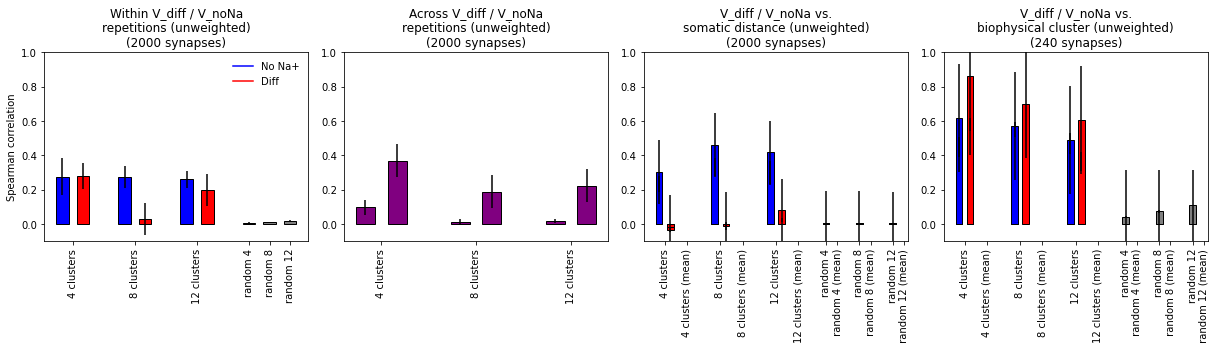

In [60]:
fig, axs = plt.subplots(ncols=4, figsize=(17,5))

colors=["blue","red","blue","red","blue","red","gray","gray","gray"]
axs[0].bar([1,2,4,5,7,8,10,11,12], np.mean(within_corrs,0), width=0.6,
           color=colors, yerr=np.std(within_corrs,0), edgecolor="black")
    
hB, = axs[0].plot(1,1,'blue')
hR, = axs[0].plot(1,1,'red')
axs[0].legend((hB, hR),('No Na+', 'Diff'), frameon=False)
hB.set_visible(False)
hR.set_visible(False)

colors=["purple","purple","purple"]
axs[1].bar([1,4,7], np.mean(across_corrs,0), width=0.6,
          color=colors, yerr=np.std(across_corrs,0), edgecolor="black")
axs[1].bar([2,5,8], across_mean_corrs_weighted, width=0.6,
          color=colors, yerr=np.std(across_mean_corrs,0), edgecolor="black")

colors=["blue","red",
        "blue","red",
        "blue","red",
       "gray","gray","gray"]
axs[2].bar([1,2,6,7,11,12,16,19,22], np.mean(dist_corrs,0), width=0.6,
          color=colors, yerr=np.std(dist_corrs,0), edgecolor="black")
axs[2].bar([1,2,6,7,11,12,16,19,22], dist_mean_corrs, width=0.6,
          color=colors, yerr=np.std(dist_mean_corrs), edgecolor="black")

    
colors=["blue","red",
        "blue","red",
        "blue","red",
       "gray","gray","gray"]
axs[3].bar([1,2,6,7,11,12,16,19,22], np.mean(clust_corrs,0), width=0.6,
          color=colors, yerr=np.std(clust_corrs,0), edgecolor="black")
axs[3].bar([1,2,6,7,11,12,16,19,22], clust_mean_corrs, width=0.6,
          color=colors, yerr=np.std(clust_mean_corrs), edgecolor="black")

axs[0].set_ylim(-0.1,1)
axs[1].set_ylim(-0.1,1)
axs[2].set_ylim(-0.1,1)
axs[3].set_ylim(-0.1,1)
axs[0].set_xticks([1.5,4.5,7.5,10,11,12])
axs[1].set_xticks([1.5,4.5,7.5])
axs[2].set_xticks([1.5,3.5,6.5,8.5,11.5,13.5,
                   16,17,19,20,22,23])
axs[3].set_xticks([1.5,3.5,6.5,8.5,11.5,13.5,
                   16,17,19,20,22,23])

axs[0].set_xticklabels(["4 clusters","8 clusters","12 clusters",
                       "random 4","random 8","random 12"], rotation=90)
axs[1].set_xticklabels(["4 clusters","8 clusters","12 clusters"], rotation=90)
axs[2].set_xticklabels(["4 clusters", "4 clusters (mean)", "8 clusters", "8 clusters (mean)",
                       "12 clusters", "12 clusters (mean)",
                        "random 4", " random 4 (mean)",
                        "random 8", " random 8 (mean)",
                        "random 12", " random 12 (mean)"], rotation=90)
axs[3].set_xticklabels(["4 clusters", "4 clusters (mean)", "8 clusters", "8 clusters (mean)",
                       "12 clusters", "12 clusters (mean)",
                        "random 4", " random 4 (mean)",
                        "random 8", " random 8 (mean)",
                        "random 12", " random 12 (mean)"], rotation=90)

axs[0].set_title("Within V_diff / V_noNa\nrepetitions (unweighted)\n(2000 synapses)")
axs[1].set_title("Across V_diff / V_noNa\nrepetitions (unweighted)\n(2000 synapses)")
axs[2].set_title("V_diff / V_noNa vs.\nsomatic distance (unweighted)\n(2000 synapses)")
axs[3].set_title("V_diff / V_noNa vs.\nbiophysical cluster (unweighted)\n(240 synapses)")
axs[0].set_ylabel("Spearman correlation")

fig.tight_layout()
plt.show()

In [7]:
x, y = np.triu_indices(2000, k=0)
x_part, y_part = np.triu_indices(240, k=0)
x_part += 880
y_part += 880

within_corrs_weighted = np.zeros((rep_no*(rep_no-1)//2,9))
across_corrs_weighted = np.zeros((rep_no**2,3))
dist_corrs_weighted = np.zeros((rep_no,9))
clust_corrs_weighted = np.zeros((rep_no,9))

within_mean_corrs_weighted = np.zeros((9))
across_mean_corrs_weighted = np.zeros((3))
dist_mean_corrs_weighted = np.zeros((9))
clust_mean_corrs_weighted = np.zeros((9))

C4_diff_scale_mat_all = np.matmul(C4_diff_scale_all.reshape(rep_no,-1,1), C4_diff_scale_all.reshape(rep_no,1,-1))
C4_nona_scale_mat_all = np.matmul(C4_nona_scale_all.reshape(rep_no,-1,1), C4_nona_scale_all.reshape(rep_no,1,-1))
C8_diff_scale_mat_all = np.matmul(C8_diff_scale_all.reshape(rep_no,-1,1), C8_diff_scale_all.reshape(rep_no,1,-1))
C8_nona_scale_mat_all = np.matmul(C8_nona_scale_all.reshape(rep_no,-1,1), C8_nona_scale_all.reshape(rep_no,1,-1))
C12_diff_scale_mat_all = np.matmul(C12_diff_scale_all.reshape(rep_no,-1,1), C12_diff_scale_all.reshape(rep_no,1,-1))
C12_nona_scale_mat_all = np.matmul(C12_nona_scale_all.reshape(rep_no,-1,1), C12_nona_scale_all.reshape(rep_no,1,-1))
C4_rand_scale_mat_all = np.matmul(C4_rand_scale_all.reshape(rep_no,-1,1), C4_rand_scale_all.reshape(rep_no,1,-1))
C8_rand_scale_mat_all = np.matmul(C8_rand_scale_all.reshape(rep_no,-1,1), C8_rand_scale_all.reshape(rep_no,1,-1))
C12_rand_scale_mat_all = np.matmul(C12_rand_scale_all.reshape(rep_no,-1,1), C12_rand_scale_all.reshape(rep_no,1,-1))

C4_diff_scale_mat_mean = np.matmul(C4_diff_scale_mean.reshape(-1,1), C4_diff_scale_mean.reshape(1,-1))
C4_nona_scale_mat_mean = np.matmul(C4_nona_scale_mean.reshape(-1,1), C4_nona_scale_mean.reshape(1,-1))
C8_diff_scale_mat_mean = np.matmul(C8_diff_scale_mean.reshape(-1,1), C8_diff_scale_mean.reshape(1,-1))
C8_nona_scale_mat_mean = np.matmul(C8_nona_scale_mean.reshape(-1,1), C8_nona_scale_mean.reshape(1,-1))
C12_diff_scale_mat_mean = np.matmul(C12_diff_scale_mean.reshape(-1,1), C12_diff_scale_mean.reshape(1,-1))
C12_nona_scale_mat_mean = np.matmul(C12_nona_scale_mean.reshape(-1,1), C12_nona_scale_mean.reshape(1,-1))
C4_rand_scale_mat_mean = np.matmul(C4_rand_scale_mean.reshape(-1,1), C4_rand_scale_mean.reshape(1,-1))
C8_rand_scale_mat_mean = np.matmul(C8_rand_scale_mean.reshape(-1,1), C8_rand_scale_mean.reshape(1,-1))
C12_rand_scale_mat_mean = np.matmul(C12_rand_scale_mean.reshape(-1,1), C12_rand_scale_mean.reshape(1,-1))

for i in tnrange(3):
    if i == 0:
        dist_mat = C4_dist
        clust_mat = C4_clust
        diff_mat_all = C4_diff_all
        nona_mat_all = C4_nona_all
        diff_scale_mat_all = C4_diff_scale_mat_all
        nona_scale_mat_all = C4_nona_scale_mat_all
        diff_mat_mean = C4_diff_mean
        nona_mat_mean = C4_nona_mean
        diff_scale_mat_mean = C4_diff_scale_mat_mean
        nona_scale_mat_mean = C4_nona_scale_mat_mean
        rand_mat_all = C4_rand_all
        rand_mat_mean = C4_rand_mean
        rand_scale_mat_all = C4_rand_scale_mat_all
        rand_scale_mat_mean = C4_rand_scale_mat_mean
    elif i == 1:
        dist_mat = C8_dist
        clust_mat = C8_clust
        diff_mat_all = C8_diff_all
        nona_mat_all = C8_nona_all
        diff_scale_mat_all = C8_diff_scale_mat_all
        nona_scale_mat_all = C8_nona_scale_mat_all
        diff_mat_mean = C8_diff_mean
        nona_mat_mean = C8_nona_mean
        diff_scale_mat_mean = C8_diff_scale_mat_mean
        nona_scale_mat_mean = C8_nona_scale_mat_mean
        rand_mat_all = C8_rand_all
        rand_mat_mean = C8_rand_mean
        rand_scale_mat_all = C8_rand_scale_mat_all
        rand_scale_mat_mean = C8_rand_scale_mat_mean
    elif i == 2:
        dist_mat = C12_dist
        clust_mat = C12_clust
        diff_mat_all = C12_diff_all
        nona_mat_all = C12_nona_all
        diff_scale_mat_all = C12_diff_scale_mat_all
        nona_scale_mat_all = C12_nona_scale_mat_all
        diff_mat_mean = C12_diff_mean
        nona_mat_mean = C12_nona_mean
        diff_scale_mat_mean = C12_diff_scale_mat_mean
        nona_scale_mat_mean = C12_nona_scale_mat_mean
        rand_mat_all = C12_rand_all
        rand_mat_mean = C12_rand_mean
        rand_scale_mat_all = C12_rand_scale_mat_all
        rand_scale_mat_mean = C12_rand_scale_mat_mean
        
    across_count = 0
    within_count = 0
    for j in range(rep_no):
        for k in range(rep_no):
            weight = diff_scale_mat_all[j][x,y] * nona_scale_mat_all[k][x,y]
            across_corr_val = WeightedCorr(x=pd.Series(diff_mat_all[j][x,y]),
                   y=pd.Series(nona_mat_all[k][x,y]),
                   w=pd.Series(weight))(method='spearman')
            across_corrs_weighted[across_count,i] = across_corr_val
            across_count += 1
        for k in range(j+1,rep_no,1):
            diff_weight = diff_scale_mat_all[j][x,y] * diff_scale_mat_all[k][x,y]
            nona_weight = nona_scale_mat_all[j][x,y] * nona_scale_mat_all[k][x,y]
            within_diff_corr_val = WeightedCorr(x=pd.Series(diff_mat_all[j][x,y]),
                   y=pd.Series(diff_mat_all[k][x,y]),
                   w=pd.Series(diff_weight))(method='spearman')
            within_nona_corr_val = WeightedCorr(x=pd.Series(nona_mat_all[j][x,y]),
                   y=pd.Series(nona_mat_all[k][x,y]),
                   w=pd.Series(nona_weight))(method='spearman')
            within_corrs_weighted[within_count,i*2] = within_nona_corr_val
            within_corrs_weighted[within_count,i*2+1] = within_diff_corr_val
            
            rand_weight = rand_scale_mat_all[j][x,y] * rand_scale_mat_all[k][x,y]
            within_rand_corr_val = WeightedCorr(x=pd.Series(rand_mat_all[j][x,y]),
                   y=pd.Series(rand_mat_all[k][x,y]),
                   w=pd.Series(rand_weight))(method='spearman')
            within_corrs_weighted[within_count,i+6] = within_rand_corr_val            
            
            within_count += 1
        
        nona_weight = nona_scale_mat_all[j][x,y]
        diff_weight = diff_scale_mat_all[j][x,y]
        dist_nona_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(nona_mat_all[j][x,y]),
                   w=pd.Series(nona_weight))(method='spearman')
        dist_diff_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(diff_mat_all[j][x,y]),
                   w=pd.Series(diff_weight))(method='spearman')
        dist_corrs_weighted[j,i*2] = dist_nona_corr_val
        dist_corrs_weighted[j,i*2+1] = dist_diff_corr_val
        rand_weight = rand_scale_mat_all[j][x,y]
        dist_rand_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(rand_mat_all[j][x,y]),
                   w=pd.Series(rand_weight))(method='spearman')
        dist_corrs_weighted[j,i+6] = dist_rand_corr_val
        
        nona_weight_part = nona_scale_mat_all[j][x_part,y_part]
        diff_weight_part = diff_scale_mat_all[j][x_part,y_part]
        clust_nona_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(nona_mat_all[j][x_part,y_part]),
                   w=pd.Series(nona_weight_part))(method='spearman')
        clust_diff_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(diff_mat_all[j][x_part,y_part]),
                   w=pd.Series(diff_weight_part))(method='spearman')
        clust_corrs_weighted[j,i*2] = clust_nona_corr_val
        clust_corrs_weighted[j,i*2+1] = clust_diff_corr_val
        rand_weight_part = rand_scale_mat_all[j][x_part,y_part]
        clust_rand_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(rand_mat_all[j][x_part,y_part]),
                   w=pd.Series(rand_weight_part))(method='spearman')
        clust_corrs_weighted[j,i+6] = clust_rand_corr_val
        
    weight = diff_scale_mat_mean[x,y] * nona_scale_mat_mean[x,y]
    across_corr_val = WeightedCorr(x=pd.Series(diff_mat_mean[x,y]),
                   y=pd.Series(nona_mat_mean[x,y]),
                   w=pd.Series(weight))(method='spearman')
    across_mean_corrs_weighted[i] = across_corr_val
    
    nona_weight = nona_scale_mat_mean[x,y]
    diff_weight = diff_scale_mat_mean[x,y]
    dist_nona_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(nona_mat_mean[x,y]),
                   w=pd.Series(nona_weight))(method='spearman')
    dist_diff_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(diff_mat_mean[x,y]),
                   w=pd.Series(diff_weight))(method='spearman')
    dist_mean_corrs_weighted[i*2] = dist_nona_corr_val
    dist_mean_corrs_weighted[i*2+1] = dist_diff_corr_val
    rand_weight = rand_scale_mat_mean[x,y]
    dist_rand_corr_val = WeightedCorr(x=pd.Series(dist_mat[x,y]),
                   y=pd.Series(rand_mat_mean[x,y]),
                   w=pd.Series(rand_weight))(method='spearman')
    dist_mean_corrs_weighted[i+6] = dist_rand_corr_val
    
    nona_weight_part = nona_scale_mat_mean[x_part,y_part]
    diff_weight_part = diff_scale_mat_mean[x_part,y_part]
    clust_nona_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(nona_mat_mean[x_part,y_part]),
                   w=pd.Series(nona_weight_part))(method='spearman')
    clust_diff_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(diff_mat_mean[x_part,y_part]),
                   w=pd.Series(diff_weight_part))(method='spearman')
    clust_mean_corrs_weighted[i*2] = clust_nona_corr_val
    clust_mean_corrs_weighted[i*2+1] = clust_diff_corr_val
    rand_weight_part = rand_scale_mat_mean[x_part,y_part]
    clust_rand_corr_val = WeightedCorr(x=pd.Series(clust_mat[x_part,y_part]),
                   y=pd.Series(rand_mat_mean[x_part,y_part]),
                   w=pd.Series(rand_weight_part))(method='spearman')


<ipython-input-7-84c0c7d5a387>:36: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(3):


  0%|          | 0/3 [00:00<?, ?it/s]

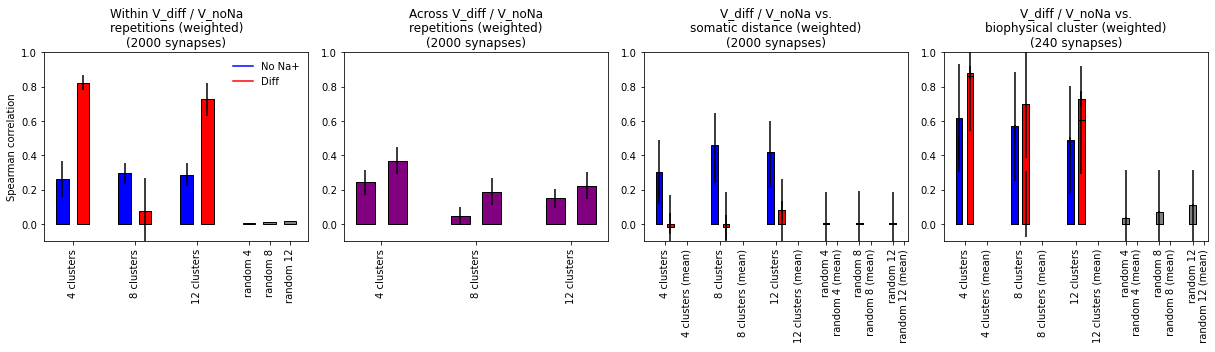

In [8]:
fig, axs = plt.subplots(ncols=4, figsize=(17,5))

colors=["blue","red","blue","red","blue","red","gray","gray","gray"]
axs[0].bar([1,2,4,5,7,8,10,11,12], np.mean(within_corrs_weighted,0), width=0.6,
           color=colors, yerr=np.std(within_corrs_weighted,0), edgecolor="black")
    
hB, = axs[0].plot(1,1,'blue')
hR, = axs[0].plot(1,1,'red')
axs[0].legend((hB, hR),('No Na+', 'Diff'), frameon=False)
hB.set_visible(False)
hR.set_visible(False)

colors=["purple","purple","purple"]
axs[1].bar([1,4,7], np.mean(across_corrs_weighted,0), width=0.6,
          color=colors, yerr=np.std(across_corrs_weighted,0), edgecolor="black")
axs[1].bar([2,5,8], across_mean_corrs_weighted, width=0.6,
          color=colors, yerr=np.std(across_mean_corrs_weighted,0), edgecolor="black")

colors=["blue","red",
        "blue","red",
        "blue","red",
       "gray","gray","gray"]
axs[2].bar([1,2,6,7,11,12,16,19,22], np.mean(dist_corrs_weighted,0), width=0.6,
          color=colors, yerr=np.std(dist_corrs_weighted,0), edgecolor="black")
axs[2].bar([1,2,6,7,11,12,16,19,22], dist_mean_corrs_weighted, width=0.6,
          color=colors, yerr=np.std(dist_mean_corrs_weighted), edgecolor="black")

    
colors=["blue","red",
        "blue","red",
        "blue","red",
       "gray","gray","gray"]
axs[3].bar([1,2,6,7,11,12,16,19,22], np.mean(clust_corrs_weighted,0), width=0.6,
          color=colors, yerr=np.std(clust_corrs_weighted,0), edgecolor="black")
axs[3].bar([1,2,6,7,11,12,16,19,22], clust_mean_corrs_weighted, width=0.6,
          color=colors, yerr=np.std(clust_mean_corrs_weighted), edgecolor="black")

axs[0].set_ylim(-0.1,1)
axs[1].set_ylim(-0.1,1)
axs[2].set_ylim(-0.1,1)
axs[3].set_ylim(-0.1,1)
axs[0].set_xticks([1.5,4.5,7.5,10,11,12])
axs[1].set_xticks([1.5,4.5,7.5])
axs[2].set_xticks([1.5,3.5,6.5,8.5,11.5,13.5,
                   16,17,19,20,22,23])
axs[3].set_xticks([1.5,3.5,6.5,8.5,11.5,13.5,
                   16,17,19,20,22,23])

axs[0].set_xticklabels(["4 clusters","8 clusters","12 clusters",
                       "random 4","random 8","random 12"], rotation=90)
axs[1].set_xticklabels(["4 clusters","8 clusters","12 clusters"], rotation=90)
axs[2].set_xticklabels(["4 clusters", "4 clusters (mean)", "8 clusters", "8 clusters (mean)",
                       "12 clusters", "12 clusters (mean)",
                        "random 4", " random 4 (mean)",
                        "random 8", " random 8 (mean)",
                        "random 12", " random 12 (mean)"], rotation=90)
axs[3].set_xticklabels(["4 clusters", "4 clusters (mean)", "8 clusters", "8 clusters (mean)",
                       "12 clusters", "12 clusters (mean)",
                        "random 4", " random 4 (mean)",
                        "random 8", " random 8 (mean)",
                        "random 12", " random 12 (mean)"], rotation=90)

axs[0].set_title("Within V_diff / V_noNa\nrepetitions (weighted)\n(2000 synapses)")
axs[1].set_title("Across V_diff / V_noNa\nrepetitions (weighted)\n(2000 synapses)")
axs[2].set_title("V_diff / V_noNa vs.\nsomatic distance (weighted)\n(2000 synapses)")
axs[3].set_title("V_diff / V_noNa vs.\nbiophysical cluster (weighted)\n(240 synapses)")
axs[0].set_ylabel("Spearman correlation")

fig.tight_layout()
plt.show()

In [73]:
C4_diff_rep_corr_weighted = np.zeros((rep_no, rep_no))
C4_nona_rep_corr_weighted = np.zeros((rep_no, rep_no))
C8_diff_rep_corr_weighted = np.zeros((rep_no, rep_no))
C8_nona_rep_corr_weighted = np.zeros((rep_no, rep_no))
C12_diff_rep_corr_weighted = np.zeros((rep_no, rep_no))
C12_nona_rep_corr_weighted = np.zeros((rep_no, rep_no))

within_count = 0
for i in range(rep_no):
    for j in range(i+1,rep_no,1):
        C4_nona_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 0]
        C4_nona_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 0]
        C4_diff_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 1]
        C4_diff_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 1]
        C8_nona_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 2]
        C8_nona_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 2]
        C8_diff_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 3]
        C8_diff_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 3]
        C12_nona_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 4]
        C12_nona_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 4]
        C12_diff_rep_corr_weighted[i,j] = within_corrs_weighted[within_count, 5]
        C12_diff_rep_corr_weighted[j,i] = within_corrs_weighted[within_count, 5]
        
        within_count += 1

C4_diff_heatmap_weighted = np.zeros((rep_no+2, rep_no))
C4_nona_heatmap_weighted = np.zeros((rep_no+2, rep_no))
C8_diff_heatmap_weighted = np.zeros((rep_no+2, rep_no))
C8_nona_heatmap_weighted = np.zeros((rep_no+2, rep_no))
C12_diff_heatmap_weighted = np.zeros((rep_no+2, rep_no))
C12_nona_heatmap_weighted = np.zeros((rep_no+2, rep_no))

C4_nona_heatmap_weighted[:rep_no,:] = C4_nona_rep_corr_weighted
C4_nona_heatmap_weighted[-2,:] = dist_corrs_weighted[:,0]
C4_diff_heatmap_weighted[:rep_no,:] = C4_diff_rep_corr_weighted
C4_diff_heatmap_weighted[-2,:] = dist_corrs_weighted[:,1]
C8_nona_heatmap_weighted[:rep_no,:] = C8_nona_rep_corr_weighted
C8_nona_heatmap_weighted[-2,:] = dist_corrs_weighted[:,2]
C8_diff_heatmap_weighted[:rep_no,:] = C8_diff_rep_corr_weighted
C8_diff_heatmap_weighted[-2,:] = dist_corrs_weighted[:,3]
C12_nona_heatmap_weighted[:rep_no,:] = C12_nona_rep_corr_weighted
C12_nona_heatmap_weighted[-2,:] = dist_corrs_weighted[:,4]
C12_diff_heatmap_weighted[:rep_no,:] = C12_diff_rep_corr_weighted
C12_diff_heatmap_weighted[-2,:] = dist_corrs_weighted[:,5]

for i in range(rep_no):
    C4_nona_rand = WeightedCorr(x=pd.Series(C4_rand_all[i][x,y]),
                   y=pd.Series(C4_nona_all[i][x,y]),
                   w=pd.Series(C4_nona_scale_mat_all[i][x,y]))(method='spearman')
    C4_diff_rand = WeightedCorr(x=pd.Series(C4_rand_all[i][x,y]),
                   y=pd.Series(C4_diff_all[i][x,y]),
                   w=pd.Series(C4_diff_scale_mat_all[i][x,y]))(method='spearman')
    C8_nona_rand = WeightedCorr(x=pd.Series(C8_rand_all[i][x,y]),
                   y=pd.Series(C4_nona_all[i][x,y]),
                   w=pd.Series(C4_nona_scale_mat_all[i][x,y]))(method='spearman')
    C8_diff_rand = WeightedCorr(x=pd.Series(C8_rand_all[i][x,y]),
                   y=pd.Series(C4_diff_all[i][x,y]),
                   w=pd.Series(C4_diff_scale_mat_all[i][x,y]))(method='spearman')
    C12_nona_rand = WeightedCorr(x=pd.Series(C12_rand_all[i][x,y]),
                   y=pd.Series(C12_nona_all[i][x,y]),
                   w=pd.Series(C12_nona_scale_mat_all[i][x,y]))(method='spearman')
    C12_diff_rand = WeightedCorr(x=pd.Series(C12_rand_all[i][x,y]),
                   y=pd.Series(C12_diff_all[i][x,y]),
                   w=pd.Series(C12_diff_scale_mat_all[i][x,y]))(method='spearman')
    
    C4_nona_heatmap[-1,i] = C4_nona_rand
    C4_diff_heatmap[-1,i] = C4_diff_rand
    C8_nona_heatmap[-1,i] = C8_nona_rand
    C8_diff_heatmap[-1,i] = C8_diff_rand
    C12_nona_heatmap[-1,i] = C12_nona_rand
    C12_diff_heatmap[-1,i] = C12_diff_rand

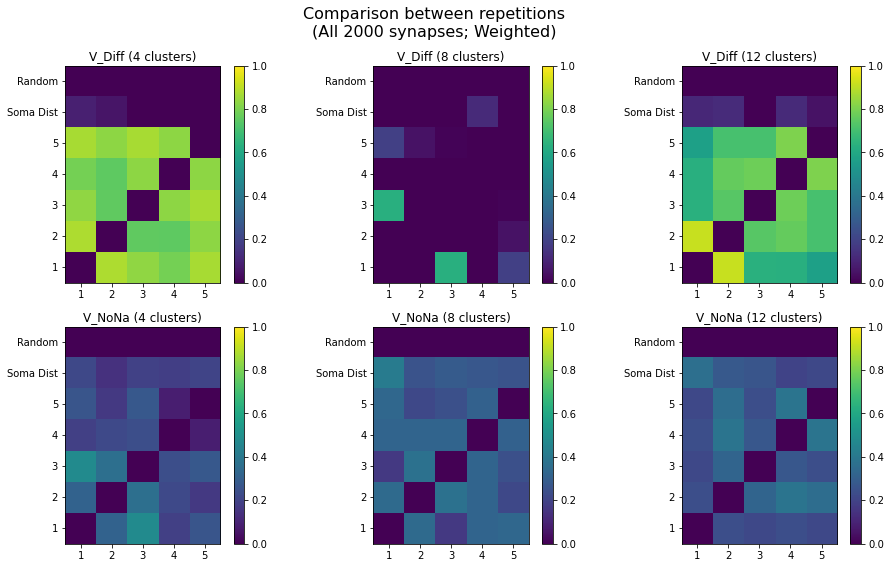

In [79]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize= (13,8))


im1 = ax[0,0].imshow(C4_diff_heatmap_weighted, origin='lower', vmin=0, vmax=1)
im2 = ax[1,0].imshow(C4_nona_heatmap_weighted, origin='lower', vmin=0, vmax=1)
im3 = ax[0,1].imshow(C8_diff_heatmap_weighted, origin='lower', vmin=0, vmax=1)
im4 = ax[1,1].imshow(C8_nona_heatmap_weighted, origin='lower', vmin=0, vmax=1)
im5 = ax[0,2].imshow(C12_diff_heatmap_weighted, origin='lower', vmin=0, vmax=1)
im6 = ax[1,2].imshow(C12_nona_heatmap_weighted, origin='lower', vmin=0, vmax=1)

plt.colorbar(im1, ax=ax[0,0])
plt.colorbar(im2, ax=ax[1,0])
plt.colorbar(im3, ax=ax[0,1])
plt.colorbar(im4, ax=ax[1,1])
plt.colorbar(im5, ax=ax[0,2])
plt.colorbar(im6, ax=ax[1,2])

ax[0,0].set_title("V_Diff (4 clusters)")
ax[1,0].set_title("V_NoNa (4 clusters)")
ax[0,1].set_title("V_Diff (8 clusters)")
ax[1,1].set_title("V_NoNa (8 clusters)")
ax[0,2].set_title("V_Diff (12 clusters)")
ax[1,2].set_title("V_NoNa (12 clusters)")

for i in range(2):
    for j in range(3):
        ax[i,j].set_xticks(np.arange(5))
        ax[i,j].set_yticks(np.arange(7))
        ax[i,j].set_xticklabels(["1","2","3","4","5"])
        ax[i,j].set_yticklabels(["1","2","3","4","5","Soma Dist", "Random"])
        
fig.suptitle("Comparison between repetitions\n(All 2000 synapses; Weighted)", y=0.98, fontsize=16)

fig.tight_layout()
plt.show()

In [94]:
C4_diff_cond_probs = np.zeros((rep_no,5,4))
C8_diff_cond_probs = np.zeros((rep_no,9,8))
C12_diff_cond_probs = np.zeros((rep_no,13,12))
C4_nona_cond_probs = np.zeros((rep_no,5,4))
C8_nona_cond_probs = np.zeros((rep_no,9,8))
C12_nona_cond_probs = np.zeros((rep_no,13,12))

for i in range(rep_no):
    C4_diff_raw = np.load("/media/hdd01/sklee/CA1_clust4-60/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"][:,880:1120]
    C8_diff_raw = np.load("/media/hdd01/sklee/CA1_clust8-30/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"][:,880:1120]
    C12_diff_raw = np.load("/media/hdd01/sklee/CA1_clust12-20/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"][:,880:1120]
    C4_nona_raw = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/clust/gru_s5_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"][:,880:1120]
    C8_nona_raw = np.load("/media/hdd01/sklee/CA1_clust8-30_noNA/clust/gru_s9_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"][:,880:1120]
    C12_nona_raw = np.load("/media/hdd01/sklee/CA1_clust12-20_noNA/clust/gru_s13_h20_pretrain_output_rep"+str(i+1)+".npz")["C_syn_e"][:,880:1120]
    
    for j in range(5):
        C4_diff_where = np.where(C4_diff_raw[j] == 1)[0]
        C4_nona_where = np.where(C4_nona_raw[j] == 1)[0]
        for k in range(4):
            C4_diff_count_no = np.where((C4_diff_where>=k*60) & (C4_diff_where<(k+1)*60))[0].size
            C4_nona_count_no = np.where((C4_nona_where>=k*60) & (C4_nona_where<(k+1)*60))[0].size
            C4_diff_cond_probs[i,j,k] = C4_diff_count_no
            C4_nona_cond_probs[i,j,k] = C4_nona_count_no

    for j in range(9):
        C8_diff_where = np.where(C8_diff_raw[j] == 1)[0]
        C8_nona_where = np.where(C8_nona_raw[j] == 1)[0]
        for k in range(8):
            C8_diff_count_no = np.where((C8_diff_where>=k*60) & (C8_diff_where<(k+1)*60))[0].size
            C8_nona_count_no = np.where((C8_nona_where>=k*60) & (C8_nona_where<(k+1)*60))[0].size
            C8_diff_cond_probs[i,j,k] = C8_diff_count_no
            C8_nona_cond_probs[i,j,k] = C8_nona_count_no
        
    for j in range(13):
        C12_diff_where = np.where(C12_diff_raw[j] == 1)[0]
        C12_nona_where = np.where(C12_nona_raw[j] == 1)[0]
        for k in range(12):
            C12_diff_count_no = np.where((C12_diff_where>=k*60) & (C12_diff_where<(k+1)*60))[0].size
            C12_nona_count_no = np.where((C12_nona_where>=k*60) & (C12_nona_where<(k+1)*60))[0].size
            C12_diff_cond_probs[i,j,k] = C12_diff_count_no
            C12_nona_cond_probs[i,j,k] = C12_nona_count_no
            
C4_diff_cond_probs = C4_diff_cond_probs / np.sum(C4_diff_cond_probs,2).reshape(rep_no, 5, 1)
C4_nona_cond_probs = C4_nona_cond_probs / np.sum(C4_nona_cond_probs,2).reshape(rep_no, 5, 1)
C8_diff_cond_probs = C8_diff_cond_probs / np.sum(C8_diff_cond_probs,2).reshape(rep_no, 9, 1)
C8_nona_cond_probs = C8_nona_cond_probs / np.sum(C8_nona_cond_probs,2).reshape(rep_no, 9, 1)
C12_diff_cond_probs = C12_diff_cond_probs / np.sum(C12_diff_cond_probs,2).reshape(rep_no, 13, 1)
C12_nona_cond_probs = C12_nona_cond_probs / np.sum(C12_nona_cond_probs,2).reshape(rep_no, 13, 1)

<ipython-input-94-784ed31a8c10>:43: RuntimeWarning: invalid value encountered in true_divide
  C4_diff_cond_probs = C4_diff_cond_probs / np.sum(C4_diff_cond_probs,2).reshape(rep_no, 5, 1)
<ipython-input-94-784ed31a8c10>:44: RuntimeWarning: invalid value encountered in true_divide
  C4_nona_cond_probs = C4_nona_cond_probs / np.sum(C4_nona_cond_probs,2).reshape(rep_no, 5, 1)
<ipython-input-94-784ed31a8c10>:45: RuntimeWarning: invalid value encountered in true_divide
  C8_diff_cond_probs = C8_diff_cond_probs / np.sum(C8_diff_cond_probs,2).reshape(rep_no, 9, 1)
<ipython-input-94-784ed31a8c10>:46: RuntimeWarning: invalid value encountered in true_divide
  C8_nona_cond_probs = C8_nona_cond_probs / np.sum(C8_nona_cond_probs,2).reshape(rep_no, 9, 1)
<ipython-input-94-784ed31a8c10>:47: RuntimeWarning: invalid value encountered in true_divide
  C12_diff_cond_probs = C12_diff_cond_probs / np.sum(C12_diff_cond_probs,2).reshape(rep_no, 13, 1)
<ipython-input-94-784ed31a8c10>:48: RuntimeWarning: inva

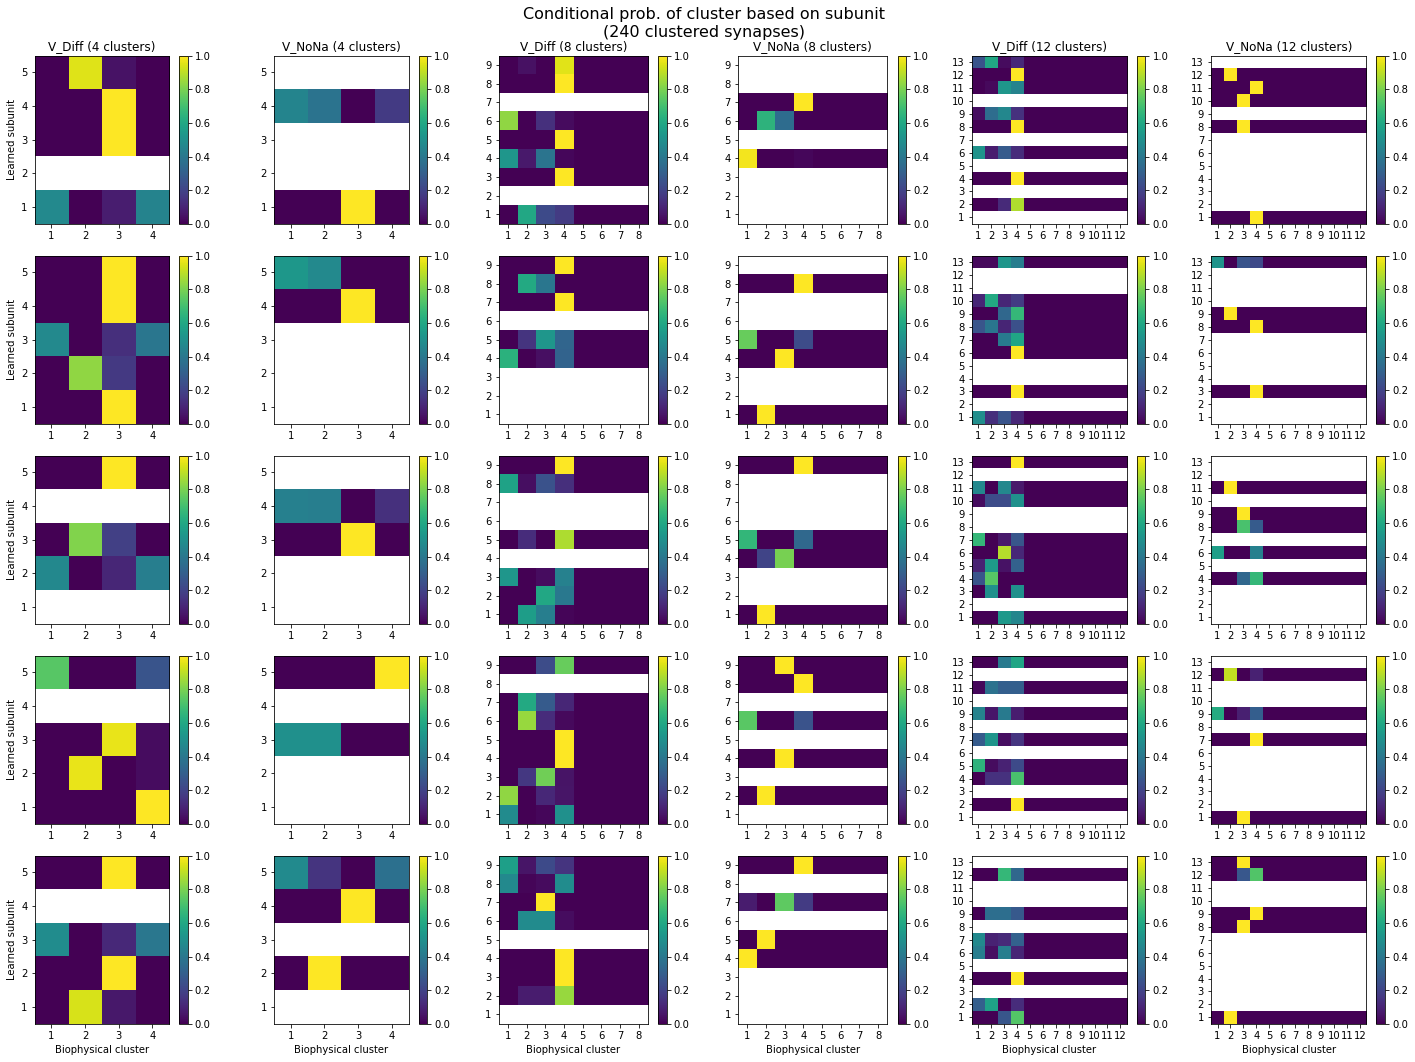

In [114]:
fig, ax = plt.subplots(nrows=rep_no, ncols=6, figsize= (20,15))

for i in range(rep_no):
    im1 = ax[i,0].imshow(C4_diff_cond_probs[i], origin="lower", vmin=0, vmax=1)
    im2 = ax[i,1].imshow(C4_nona_cond_probs[i], origin="lower", vmin=0, vmax=1)
    im3 = ax[i,2].imshow(C8_diff_cond_probs[i], origin="lower", vmin=0, vmax=1)
    im4 = ax[i,3].imshow(C8_nona_cond_probs[i], origin="lower", vmin=0, vmax=1)
    im5 = ax[i,4].imshow(C12_diff_cond_probs[i], origin="lower", vmin=0, vmax=1)
    im6 = ax[i,5].imshow(C12_nona_cond_probs[i], origin="lower", vmin=0, vmax=1)
    
    plt.colorbar(im1, ax=ax[i,0])
    plt.colorbar(im2, ax=ax[i,1])
    plt.colorbar(im3, ax=ax[i,2])
    plt.colorbar(im4, ax=ax[i,3])
    plt.colorbar(im5, ax=ax[i,4])
    plt.colorbar(im6, ax=ax[i,5])
    
    ax[i,0].set_xticks(np.arange(4))
    ax[i,0].set_xticklabels(np.arange(1,5,1))
    ax[i,0].set_yticks(np.arange(5))
    ax[i,0].set_yticklabels(np.arange(1,6,1))
    ax[i,1].set_xticks(np.arange(4))
    ax[i,1].set_xticklabels(np.arange(1,5,1))
    ax[i,1].set_yticks(np.arange(5))
    ax[i,1].set_yticklabels(np.arange(1,6,1))
    
    ax[i,2].set_xticks(np.arange(8))
    ax[i,2].set_xticklabels(np.arange(1,9,1))
    ax[i,2].set_yticks(np.arange(9))
    ax[i,2].set_yticklabels(np.arange(1,10,1))
    ax[i,3].set_xticks(np.arange(8))
    ax[i,3].set_xticklabels(np.arange(1,9,1))
    ax[i,3].set_yticks(np.arange(9))
    ax[i,3].set_yticklabels(np.arange(1,10,1))
    
    ax[i,4].set_xticks(np.arange(12))
    ax[i,4].set_xticklabels(np.arange(1,13,1))
    ax[i,4].set_yticks(np.arange(13))
    ax[i,4].set_yticklabels(np.arange(1,14,1))
    ax[i,5].set_xticks(np.arange(12))
    ax[i,5].set_xticklabels(np.arange(1,13,1))
    ax[i,5].set_yticks(np.arange(13))
    ax[i,5].set_yticklabels(np.arange(1,14,1))
    
    ax[i,0].set_ylabel("Learned subunit")
    
for i in range(6):
    ax[-1,i].set_xlabel("Biophysical cluster")
    
ax[0,0].set_title("V_Diff (4 clusters)")
ax[0,1].set_title("V_NoNa (4 clusters)")
ax[0,2].set_title("V_Diff (8 clusters)")
ax[0,3].set_title("V_NoNa (8 clusters)")
ax[0,4].set_title("V_Diff (12 clusters)")
ax[0,5].set_title("V_NoNa (12 clusters)")
    
fig.suptitle("Conditional prob. of cluster based on subunit\n(240 clustered synapses)", fontsize=16)
fig.tight_layout()
plt.show()